# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [25]:
import pandas as pd
import numpy as np
import sklearn
from mlxtend import regressor

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [41]:
from sklearn.model_selection import train_test_split

y = df['salary_in_usd']
df.drop(['salary_in_usd', 'salary', 'salary_currency'], axis=1, inplace=True)
train, test, train_y, test_y = train_test_split(df, y, test_size=0.2, random_state=17)
test, val, test_y, val_y = train_test_split(test, test_y, test_size=0.5, random_state=17)
train.head(3)

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
1995,2022,EN,FT,Data Engineer,US,0,US,M
3308,2022,SE,FT,Data Engineer,US,100,US,M
2965,2022,SE,FT,Machine Learning Infrastructure Engineer,US,100,US,M


In [42]:
print(f'exp: {df['experience_level'].unique()}')
print(f'size: {df['company_size'].unique()}')


exp: ['SE' 'MI' 'EN' 'EX']
size: ['L' 'S' 'M']


## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [43]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

def encode_train_test_val(train: pd.DataFrame,
                          test: pd.DataFrame,
                          val: pd.DataFrame,
                          encoder: OneHotEncoder | OrdinalEncoder,
                          column: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    tmp_train, tmp_test, tmp_val = train.copy(), test.copy(), val.copy()

    train_res = encoder.fit_transform(train.loc[:, [column]])
    test_res = encoder.transform(test.loc[:, [column]])
    val_res = encoder.transform(val.loc[:, [column]])
    if isinstance(encoder, OneHotEncoder):
        new_columns = encoder.get_feature_names_out([column])

        train_res = pd.DataFrame(train_res, columns=new_columns, index=train.index)
        test_res = pd.DataFrame(test_res, columns=new_columns, index=test.index)
        val_res = pd.DataFrame(val_res, columns=new_columns, index=val.index)

        tmp_train.drop(columns=[column], inplace=True)
        tmp_test.drop(columns=[column], inplace=True)
        tmp_val.drop(columns=[column], inplace=True)

        tmp_train = pd.concat([tmp_train, train_res], axis=1)
        tmp_test = pd.concat([tmp_test, test_res], axis=1)
        tmp_val = pd.concat([tmp_val, val_res], axis=1)
    elif isinstance(encoder, OrdinalEncoder):
        tmp_train[column] = train_res
        tmp_test[column] = test_res
        tmp_val[column] = val_res

    return tmp_train, tmp_test, tmp_val

In [44]:
# Наши ординальные признаки
exp_categories = [['EN', 'MI', 'SE', 'EX']]
size_categories = [['S', 'M', 'L']]
ordinal = OrdinalEncoder(categories=exp_categories)
enc_train, enc_test, enc_val = encode_train_test_val(train, test, val, ordinal, column='experience_level')
ordinal = OrdinalEncoder(categories=size_categories)
enc_train, enc_test, enc_val = encode_train_test_val(enc_train, enc_test, enc_val, ordinal, column='company_size')

# Остальные
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_features = ['employment_type', 'job_title', 'employee_residence', 'company_location']
for categorical_feature in categorical_features:
    enc_train, enc_test, enc_val = encode_train_test_val(enc_train, enc_test, enc_val, onehot, categorical_feature)

enc_train.head(3)

,work_year,experience_level,remote_ratio,company_size,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,job_title_3D Computer Vision Researcher,job_title_AI Developer,...,company_location_RU,company_location_SE,company_location_SG,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN
1995,2022,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3308,2022,2.0,100,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2965,2022,2.0,100,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, accuracy_score

linreg = LinearRegression()
linreg.fit(enc_train, train_y)
preds = linreg.predict(enc_test)

print('MAPE: ', mean_absolute_percentage_error(test_y, preds))
print('RMSE: ', mean_squared_error(test_y, preds))

MAPE:  0.3479265655786004
RMSE:  2612967589.7677026


### Изменения и их обоснование!!

experience_level намного логичнее кодировать ordinal_encoder, так как однозначно есть отношение порядка по уровню опыта

То же с company_size

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [66]:
from xgboost.sklearn import XGBRegressor
from itertools import product
import time

def build_res_df(params_dict: dict,
                 true_y: np.array,
                 predictions: np.array,
                 train_time: float,
                 prediction_time: float,
                 df: pd.DataFrame = None):
    if df is None:
        index_columns = list(params_dict.keys())
        df = pd.DataFrame(columns = index_columns + ['train_time', 'prediction_time', 'MAPE', 'RMSE'])
        df.set_index(index_columns, inplace=True)

    idx_values = list(params_dict.values())

    df.loc[tuple(idx_values)] = [
        train_time,
        prediction_time,
        mean_absolute_percentage_error(true_y, predictions),
        mean_squared_error(true_y, predictions)
    ]

    return df

def find_best_params_df(params_dict: dict, regressor) \
    -> (pd.DataFrame, float):
    overall_start_time = time.time()
    df = None
    keys = list(params_dict.keys())
    for values in product(*[params_dict[k] for k in keys]):
        param_dict = dict(zip(keys, values))

        reg = regressor(**param_dict, random_state=17)
        start_train = time.time()
        reg.fit(enc_train, train_y)
        end_train = time.time()
    
        start_pred = time.time()
        preds = reg.predict(enc_val)
        end_pred = time.time()
    
        train_time = end_train - start_train
        predict_time = end_pred - start_pred
        df = build_res_df(param_dict,
                          val_y,
                          preds,
                          train_time,
                          predict_time,
                          df)
    df.sort_values(by=['MAPE', 'RMSE'], ascending=True, inplace=True)
    overall_end_time = time.time()
    overall_time = overall_end_time - overall_start_time
    
    return df, overall_time

def evaluate_best_model(df: pd.DataFrame, regressor, overall_time: float):
    best_params = list(df.index[0])
    for i, x in enumerate(best_params):
        if isinstance(x, np.int64):
            best_params[i] = int(x)

    reg = regressor(
        **dict(zip(df.index.names, best_params)),
        random_state=17
    )

    reg.fit(enc_train, train_y)
    pred = reg.predict(enc_test)

    print(f'Всего гиперпараметры жбонкались: {overall_time} с')
    print(f'За это время я выпил: {overall_time / 60:.2f} смузи\n')

    print('MAPE: ', mean_absolute_percentage_error(test_y, pred))
    print('RMSE: ', mean_squared_error(test_y, pred))

    return reg

In [50]:
params = {
    'max_depth' : [1, 3, 5, 7, 10, 20],
    'learning_rate' : [0.01, 0.05, 0.1, 0.5],
    'n_estimators' : [1, 10, 50, 100, 250],
    'gamma' : [0, 0.1, 0.5, 1]
}

df, overall_time = find_best_params_df(params, XGBRegressor)
evaluate_best_model(df, XGBRegressor, overall_time)

df.head(3)

Всего гиперпараметры жбонкались: 65.8105239868164 с
За это время я выпил: 1.10 смузи

MAPE:  0.3163871169090271
RMSE:  2345431808.0


train_time  prediction_time  \
max_depth learning_rate n_estimators gamma                                
20        0.5           10           0.0      0.059817         0.006346   
                                     0.1      0.063213         0.005963   
                                     0.5      0.066041         0.006442   

                                                MAPE          RMSE  
max_depth learning_rate n_estimators gamma                          
20        0.5           10           0.0    0.327606  2.630021e+09  
                                     0.1    0.327606  2.630021e+09  
                                     0.5    0.327606  2.630021e+09

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [59]:
df

train_time  prediction_time  \
max_depth learning_rate iterations verbose                                
4         0.50          100        False      0.112059         0.003150   
                        250        False      0.246977         0.003199   
                        50         False      0.067788         0.003246   
16        0.10          250        False    147.544856         0.004269   
8         0.50          250        False      0.513144         0.003901   
...                                                ...              ...   
          0.01          1          False      0.026075         0.002913   
4         0.01          1          False      0.023724         0.002426   
2         0.01          1          False      0.024605         0.002531   
16        0.01          1          False      0.062818         0.002736   
1         0.01          1          False      0.023963         0.002443   

                                                MAPE          RMSE  verbose  
max_depth learning_rate iterations verbose                                   
4         0.50          100        False    0.370123  2.569138e+09        0  
                        250        False    0.374255  2.666947e+09        0  
                        50         False    0.379318  2.555879e+09        0  
16        0.10          250        False    0.380052  2.592533e+09        0  
8         0.50          250        False    0.381458  2.643476e+09        0  
...                                              ...           ...      ...  
          0.01          1          False    0.872502  4.895498e+09        0  
4         0.01          1          False    0.872607  4.896472e+09        0  
2         0.01          1          False    0.872778  4.899497e+09        0  
16        0.01          1          False    0.872794  4.896596e+09        0  
1         0.01          1          False    0.873640  4.906208e+09        0  

[100 rows x 5 columns]

In [60]:
from catboost import CatBoostRegressor

params = {
    'max_depth' : [2, 4, 8, 16],
    'learning_rate' : [0.1, 0.5],
    'iterations' : [50, 100, 250],
    'verbose': [0]
}

df, overall_time = find_best_params_df(params, CatBoostRegressor)
evaluate_best_model(df, CatBoostRegressor, overall_time)

CatBoostError: Parameter verbose should have a type of (<class 'bool'>, <class 'int'>), got <class 'numpy.int64'>

In [67]:
evaluate_best_model(df, CatBoostRegressor, overall_time)

Всего гиперпараметры жбонкались: 496.55958247184753 с
За это время я выпил: 8.28 смузи

MAPE:  0.33081574032324484
RMSE:  2173296840.6260657


In [55]:
df.head(5)

train_time  prediction_time  \
max_depth learning_rate iterations verbose                                
4         0.5           100        False      0.112059         0.003150   
                        250        False      0.246977         0.003199   
                        50         False      0.067788         0.003246   
16        0.1           250        False    147.544856         0.004269   
8         0.5           250        False      0.513144         0.003901   

                                                MAPE          RMSE  
max_depth learning_rate iterations verbose                          
4         0.5           100        False    0.370123  2.569138e+09  
                        250        False    0.374255  2.666947e+09  
                        50         False    0.379318  2.555879e+09  
16        0.1           250        False    0.380052  2.592533e+09  
8         0.5           250        False    0.381458  2.643476e+09

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from catboost import Pool

# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
from lightgbm import LGBMRegressor

'''
params = {
    'max_depth' : # -- YOUR CODE HERE -- ,
    'learning_rate' : # -- YOUR CODE HERE -- ,
    'n_estimators' : # -- YOUR CODE HERE -- ,
    # -- YOUR CODE HERE --
}

# -- YOUR CODE HERE --'''

In [ ]:
'''# -- YOUR CODE HERE --

print('MAPE: ', # -- YOUR CODE HERE -- )
print('RMSE: ', # -- YOUR CODE HERE -- )'''

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** # -- YOUR ANSWER HERE --

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [42]:
import pandas as pd
ratings = pd.read_excel('sample_matrix.xlsx')
#ratings.head()

Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [43]:
ratings = ratings.transpose()
#ratings.head(3)

Выкиньте строку под названием `user`.

In [44]:
ratings.drop('user', inplace=True)
#ratings.sample()

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [45]:
ratings.fillna(0, inplace=True)
#ratings.sample()

## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(ratings)
kmeans.labels_

array([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 0,
       0, 3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0,
       3, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 3, 0, 0, 3, 0, 0,
       0, 3, 3, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 3,
       0, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 3, 3, 3,
       3, 0, 3, 0, 0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3,
       3, 0, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 0, 3, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [47]:
def get_cluster_sizes(clusterizer) -> pd.DataFrame:
    cluster_data = []
    for i in range(len(clusterizer.cluster_centers_)):
        cluster_data.append({
            'Cluster': i,
            'Center': clusterizer.cluster_centers_[i],
            'Size': sum(clusterizer.labels_ == i)
        })
    return pd.DataFrame(cluster_data)
df_clusters = get_cluster_sizes(kmeans)
df_clusters

,Cluster,Center,Size
0,0,"[0.003761648638120636, 0.005112781954887217, 0...",115
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,3,"[0.0006433224564808687, 0.00046715428025846824...",882
4,4,"[0.0, 0.0, 0.0, 0.0, 0.04352895452778857, 0.0,...",1


**Ответ:** 88% объектов были отнесены к одному кластеру, 11% - к другому, из-за чего кластеризация получилась практически бесполезной

Скорее всего, между кластерами нет очень четкого разделения расстоянием, из-за чего почти все новые центроиды сошлись в одну или другую

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [48]:
single_point_clusters = df_clusters[df_clusters['Size'] == 1]['Cluster'].tolist()
single_point_indices = [idx for idx, label in enumerate(kmeans.labels_)
                        if label in single_point_clusters]
ratings.index[single_point_indices].tolist()

['the beatles', 'niИ', '日dir en grey']

Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [49]:
mn = np.mean(ratings.mean(axis=1))
bt_mn = np.mean(ratings.loc['the beatles'])
print(f'Средняя доля слушателей группы: {mn}')
print(f'Средняя доля слушателей The Beatles: {bt_mn}')
print(f'Доля слушателей beatles в {bt_mn/mn} раз больше среднего по датафрейму')

Средняя доля слушателей группы: 0.0009932
Средняя доля слушателей The Beatles: 0.01836897659205146
Доля слушателей beatles в 18.494740829693374 раз больше среднего по датафрейму


**Ответ:** the beatles настолько сильно отличается от большинства других групп по параметрам, что модель вполне оправданно посчитала их отдельным кластером (правда нам такой кластер не нужен, так что сейчас мы будем это исправлять)

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [51]:
from sklearn.preprocessing import normalize

norm_ratings = pd.DataFrame(normalize(ratings), columns=ratings.columns)

ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
bonnie prince billy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.009383,0.0,0.0,0.0,0.0,0.0


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [52]:
kmeans_norm = KMeans(n_clusters=5, random_state=42)
kmeans_norm.fit(norm_ratings)

norm_clusters = get_cluster_sizes(kmeans_norm)
norm_clusters

,Cluster,Center,Size
0,0,"[0.001678300663932528, -4.336808689942018e-19,...",79
1,1,"[0.0018858922539513787, 0.00010665493668881665...",162
2,2,"[0.0003558214392137668, 0.00014424023735351045...",133
3,3,"[-1.3010426069826053e-18, 0.001605513912340299...",140
4,4,"[0.0021407191276007417, 0.0019380089983257079,...",486


**Ответ** да!! Однозначно стало лучше, теперь получились вполне себе нормальные кластеры, которые можно зачем-нибудь использовать

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [79]:
from scipy.spatial.distance import cosine

def get_top_n_for_clusters(clusterizer, dataset: pd.DataFrame, n:int = 10) -> pd.DataFrame:
    centroids = clusterizer.cluster_centers_
    cluster_rows = []
    for i in range(clusterizer.n_clusters):
        distances = [cosine(centroids[i], dataset.iloc[j]) for j in range(len(dataset))]
    
        top10_indices = np.argsort(distances)[:n]
        top10_artists = dataset.index[top10_indices]
    
        row = {'Cluster': i + 1}
        for j, artist in enumerate(top10_artists, 1):
            row[j] = ratings.index[artist]
    
        cluster_rows.append(row)
        
    clusters_df = pd.DataFrame(cluster_rows).set_index('Cluster')
    clusters_df.columns = [str(i) for i in range(1, n+1)]
    
    return clusters_df

clusters_df = get_top_n_for_clusters(kmeans_norm, norm_ratings)
clusters_df

,1,2,3,4,5,6,7,8,9,10
Cluster,,,,,,,,,,
1,nas,jay-z,kanye west,lupe the gorilla,a tribe called quest,the roots featuring d'angelo,gangstarr,little brother,lil' wayne,murs and 9th wonder
2,fall out boy,the all-americian rejects,paramore,kelly clarkson,john mayer,the fray,maroon5,dashboard confesssional,somethings corporate,coldplay
3,brand new,blink-182,alkaline trio,against me!,underoath,descendents,new found glory,less than jake,thrice,chiodos
4,the beatles,the rolling stones,dylan. bob,who,led zeppelin.,miles davis.,simon and garfunkel,"young, neil",pink fluid,velvet underground
5,radiohead,the arcade fire,the shins,sufjan stevens,belle and sebastian,broken social scene,the pixies,animal collective,modest mouse,spoon


**Ответ:** КЛАСТЕРЫ РЕАЛЬНО РАЗБИЛИ ГРУППЫ ПО ЖАНРАМ, ВАУ

Логично, что чаще всего человек слушает группы +- в одном жанре. Здесь кластеры сгруппировались на основании того, что люди с похожими вкусами слушают похожие треки. Ещё один интересный момент, это что наиболее близкие к центроиде группы являются наиболее популярными представителями жанра

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

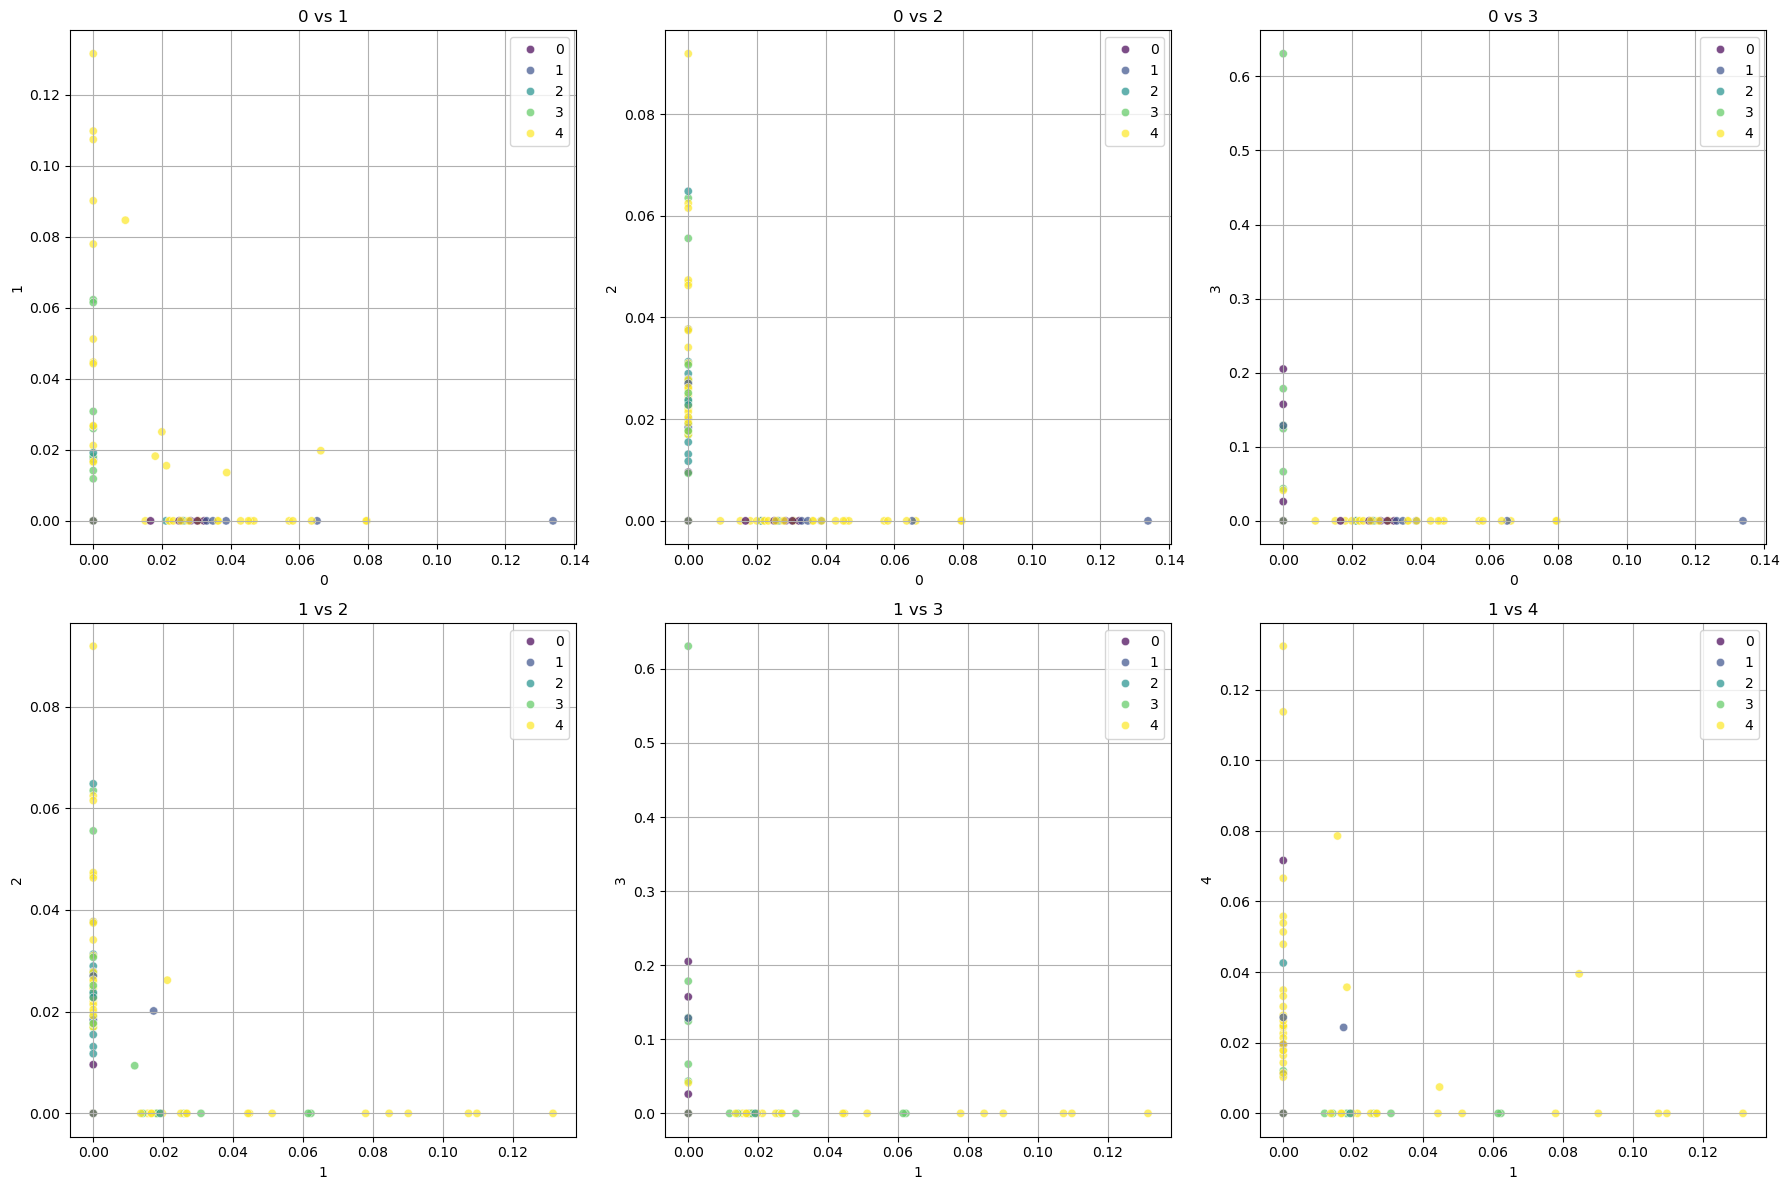

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))
clusters = kmeans_norm.labels_
features = norm_ratings.columns.tolist()

selected_pairs = []
for i in range(min(6, len(features))):
    for j in range(i+1, min(i+4, len(features))):
        if len(selected_pairs) < 6:
            selected_pairs.append((features[i], features[j]))
        
for k, (x_feat, y_feat) in enumerate(selected_pairs[:6], 1):
    plt.subplot(2, 3, k)
    sns.scatterplot(x=norm_ratings[x_feat],
                    y=norm_ratings[y_feat],
                    hue=clusters,
                    palette='viridis',
                    alpha=0.7)
    plt.title(f'{x_feat} vs {y_feat}')
    plt.xlabel(x_feat)
    plt.ylabel(y_feat)
    plt.grid(True)
        
plt.tight_layout()
plt.show()

**Ответ:** графики абсолютно неинформативные, поскольку ни по какой паре признаков нельзя нормально разделить выборку на кластеры

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

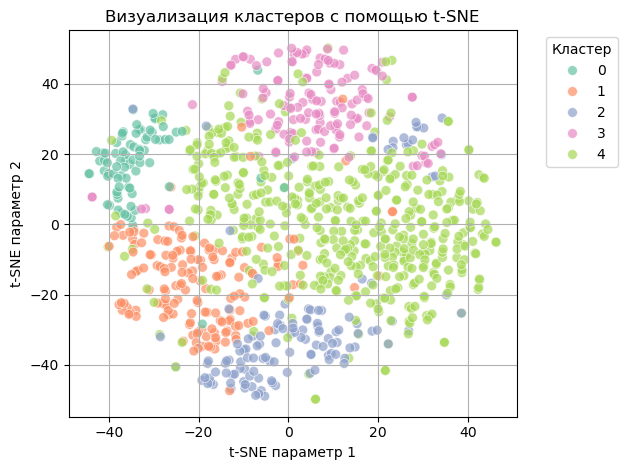

In [70]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
tsne_ratings = tsne.fit_transform(norm_ratings)

sns.scatterplot(x=tsne_ratings[:, 0],
                y=tsne_ratings[:, 1],
                hue=kmeans_norm.labels_,
                palette='Set2',
                alpha=0.7,
                s=50)

plt.title('Визуализация кластеров с помощью t-SNE')
plt.xlabel('t-SNE параметр 1')
plt.ylabel('t-SNE параметр 2')
plt.grid(True)
plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [80]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
max_clusters = min(100, len(norm_ratings)-1)
k_range = range(2, max_clusters+1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(norm_ratings)
    silhouette_avg = silhouette_score(norm_ratings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

In [81]:
sil_df = pd.DataFrame(silhouette_scores, columns=['Score'])
sil_df.sort_values(by=['Score'], ascending=False, inplace=True)
sil_df.head(5)

,Score
96,0.013327
97,0.013273
98,0.013168
95,0.013100
94,0.012911


**96** выдал наибольший индекс Силуэта, следовательно это лучшее количество кластеров

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [82]:
kmeans_96 = KMeans(n_clusters=96, random_state=42)
kmeans_96.fit(norm_ratings)
df_clusters_96 = get_top_n_for_clusters(kmeans_96, norm_ratings, 5)
df_clusters_96

,1,2,3,4,5
Cluster,,,,,
1,dr. dre,the faint,violent femmes,margot and the nuclear so and sos,owen
2,john mayer,matt nathanson,gavin degraw,jason mraz,ray lamontagne
3,white stripes,beck,the raconteurs,spoon,the pixies
4,fugazi,jawbreaker,sleater-kinney,les savy fav,bad brains
5,ryan adams,band of horses,ryan adams and the cardinals,rogue wave,my morning jacket
...,...,...,...,...,...
92,vnv nation,kmfdm,rammstein,ministry,skinny puppy
93,zimmer,lord of the rings,john williams (g),apocalyptica,danny elfman
94,andrew jackson jihad,dillinger four,the glaslight anthem,mattandkim,wolf parade


**Ответ:** я в шоке, оно реально очень круто работает - на этот раз ввиду большего количества кластеров, исполнители в кластерах ещё сильнее похожи друг на друга. 

Дальше приведены топ 6 кластеров по моему личному (самому объективному в мире) мнению

In [87]:
df_clusters_96.loc[[39, 57, 50, 74, 72, 80]]

,1,2,3,4,5
Cluster,,,,,
39,lady gaga,brritney spears,tatu,pink*,madonna
57,the killers,coldplay,muse,keane,phoenix
50,fall out boy,the academy is...,cobra starship,taking back sunday,paramore
74,Бах Иоганн Себастьян,ВИВАЛЬДИ,Вольфганг Амадей Моцарт,ШОПЕН,ルートヴィヒ・ヴァン・ベートーヴェン
72,the cardigans,mew,burial,the cranberries,jethro tull
80,foo fighters,red hot clili peppers,incubus,nirvana,pearl jam


Сделайте t-SNE визуализацию полученной кластеризации.

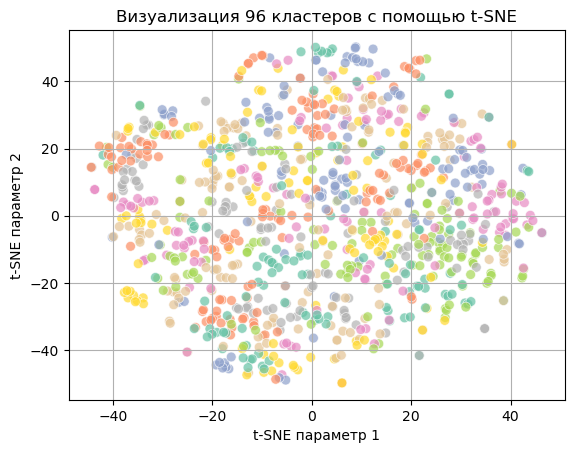

In [92]:
sns.scatterplot(x=tsne_ratings[:, 0],
                y=tsne_ratings[:, 1],
                hue=kmeans_96.labels_,
                palette='Set2',
                alpha=0.7,
                s=50)

plt.title('Визуализация 96 кластеров с помощью t-SNE')
plt.xlabel('t-SNE параметр 1')
plt.ylabel('t-SNE параметр 2')
plt.grid(True)
plt.legend().remove()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

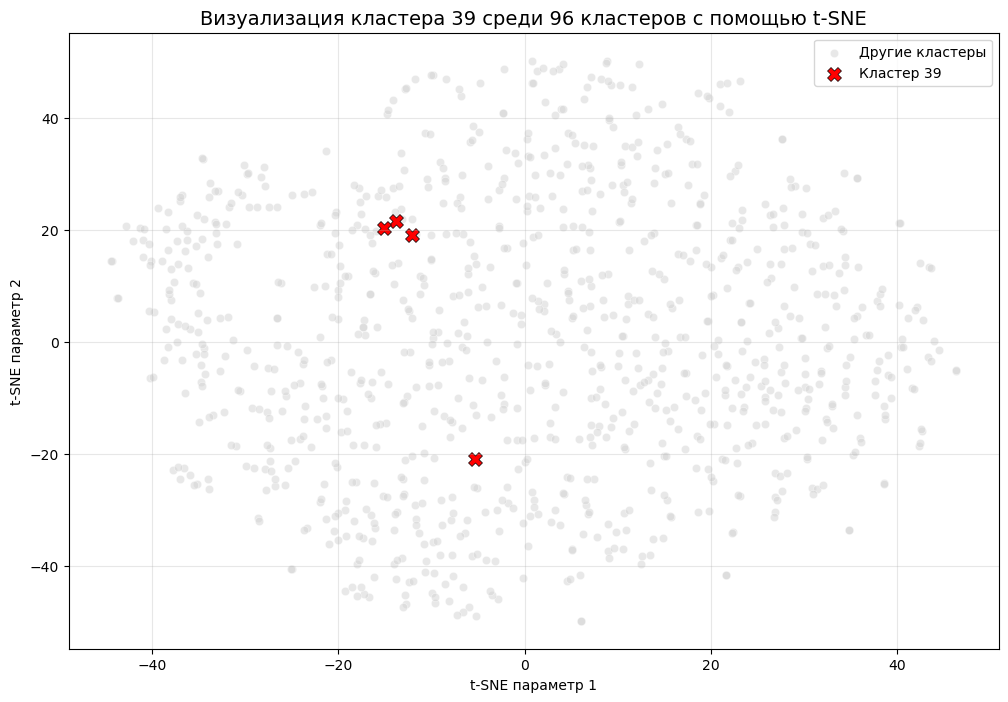

In [99]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x=tsne_ratings[:, 0],
                y=tsne_ratings[:, 1],
                color='lightgray',
                alpha=0.5,
                label='Другие кластеры')

sns.scatterplot(x=tsne_ratings[kmeans_96.labels_ == 39, 0],
                y=tsne_ratings[kmeans_96.labels_ == 39, 1],
                color='red',
                s=100,  # увеличенный размер
                marker='X',  # другой маркер
                edgecolor='black',
                linewidth=0.5,
                label='Кластер 39')

plt.title('Визуализация кластера 39 среди 96 кластеров с помощью t-SNE', fontsize=14)
plt.xlabel('t-SNE параметр 1')
plt.ylabel('t-SNE параметр 2')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

**Ответ:** получилось не очень. Видимо, в данном случае t-SNE всё-таки не очень хорошо справляется с данной задачей, либо при таком большом количестве кластеров в один могут попасть даже не самые близкие. Интересным вопросом остаётся, выделяется ли Леди Гага, или кто-то ещё....